In [15]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torchvision.models as models


model = models.resnet50(pretrained=True)
model.fc = torch.nn.Linear(2048, 100) 

model = model.to('cuda') 
model.eval()  


E:\learning\EEG\pythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
E:\learning\EEG\pythonProject\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)


In [22]:
import os 
save_dir = './model_weights_resnet50_cifar'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [34]:

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
      
        optimizer.zero_grad()
        
       
        outputs = model(inputs)
        
       
        loss = criterion(outputs, labels)
        
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
       
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}, Accuracy: {100 * correct / total:.2f}%")
    model_save_path = os.path.join(save_dir, f"resnet50_epoch_{epoch+1}.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Model weights saved to {model_save_path}")


model.eval() 
correct = 0
total = 0

with torch.no_grad():  # Disable gradient calculation for evaluation
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Epoch [1/20], Loss: 2.2143, Accuracy: 41.03%
Model weights saved to ./model_weights_resnet50_cifar\resnet50_epoch_1.pth
Epoch [2/20], Loss: 2.1853, Accuracy: 41.68%
Model weights saved to ./model_weights_resnet50_cifar\resnet50_epoch_2.pth
Epoch [3/20], Loss: 2.1725, Accuracy: 42.01%
Model weights saved to ./model_weights_resnet50_cifar\resnet50_epoch_3.pth
Epoch [4/20], Loss: 2.1564, Accuracy: 42.57%
Model weights saved to ./model_weights_resnet50_cifar\resnet50_epoch_4.pth
Epoch [5/20], Loss: 2.1432, Accuracy: 42.73%
Model weights saved to ./model_weights_resnet50_cifar\resnet50_epoch_5.pth
Epoch [6/20], Loss: 2.1297, Accuracy: 42.90%
Model weights saved to ./model_weights_resnet50_cifar\resnet50_epoch_6.pth


KeyboardInterrupt: 

In [44]:
from captum.attr import Attribution
from torch.nn import ReLU

class LRP(Attribution):
    def __init__(self, model):
        super().__init__(model)
        self.model = model
    
    def attribute(self, inputs, target=None):
        self.model.eval()
        inputs.requires_grad = True
        output = self.model(inputs)
        
        if target is None:
            target = torch.argmax(output, dim=1)
        
        one_hot = torch.zeros_like(output).scatter_(1, target.view(-1, 1), 1)
        output.backward(gradient=one_hot)
        
        relevance = inputs.grad * inputs
        return relevance


In [45]:
lrp = LRP(model)



tensor([92, 70, 16, 56, 15], device='cuda:0')


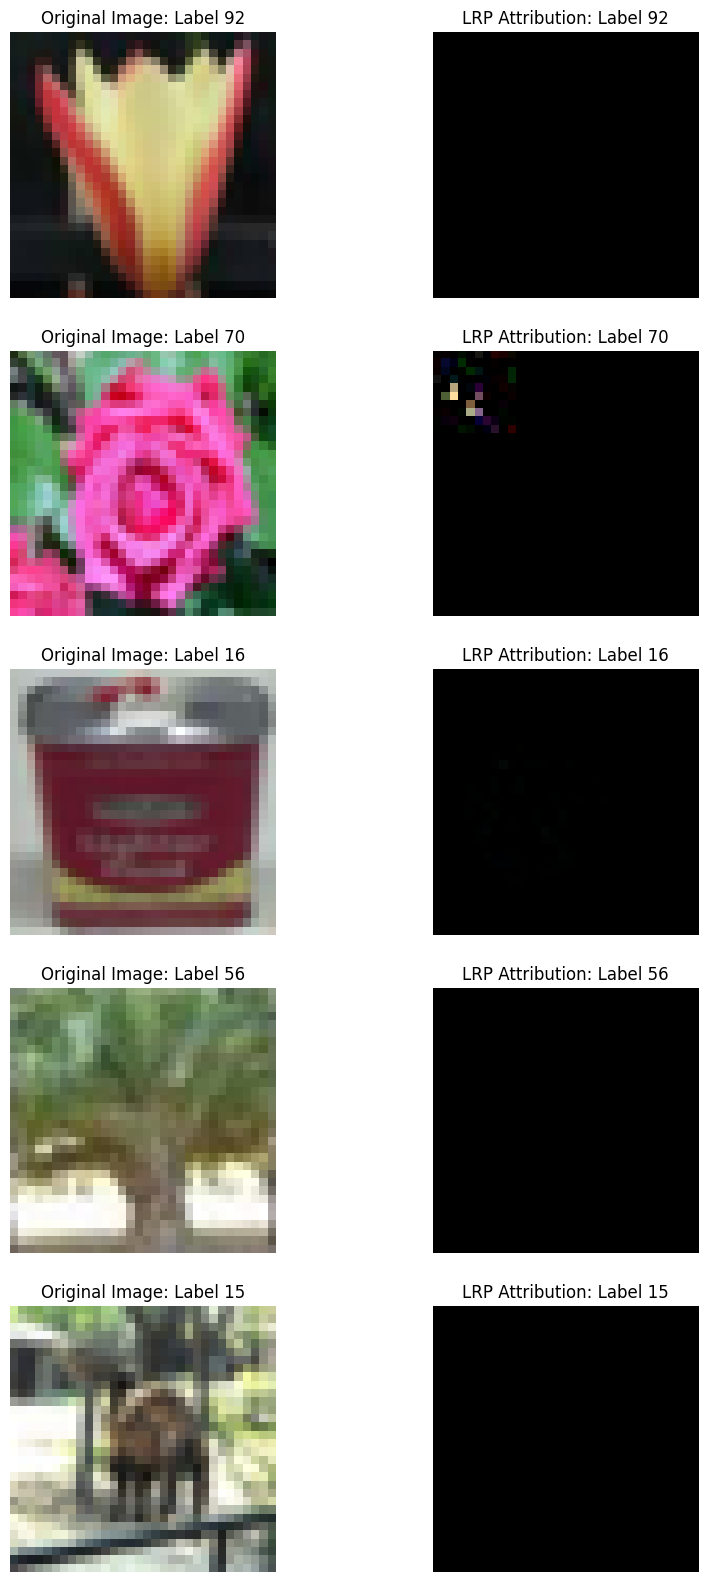

In [54]:
import random

def imshow(images, labels, attributions):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(attributions, torch.Tensor):
        attributions = attributions.detach().cpu().numpy()

    images = images / 2 + 0.5
    attributions = np.maximum(attributions, 0) 
    attributions = attributions - np.min(attributions) 
    attributions = attributions / np.max(attributions) 

    fig, axes = plt.subplots(5, 2, figsize=(10, 20))

    for i in range(5):
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title(f"Original Image: Label {labels[i]}")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(np.transpose(attributions[i], (1, 2, 0)), cmap='jet')
        axes[i, 1].set_title(f"LRP Attribution: Label {labels[i]}")
        axes[i, 1].axis('off')

    plt.show()

data_iter = iter(testloader)
images, labels = next(data_iter)

random_indices = random.sample(range(images.size(0)), 5)

selected_images = images[random_indices].to('cuda')
selected_labels = labels[random_indices].to('cuda')

print(selected_labels)

attributions = lrp.attribute(selected_images, target=selected_labels)

imshow(selected_images, selected_labels, attributions)


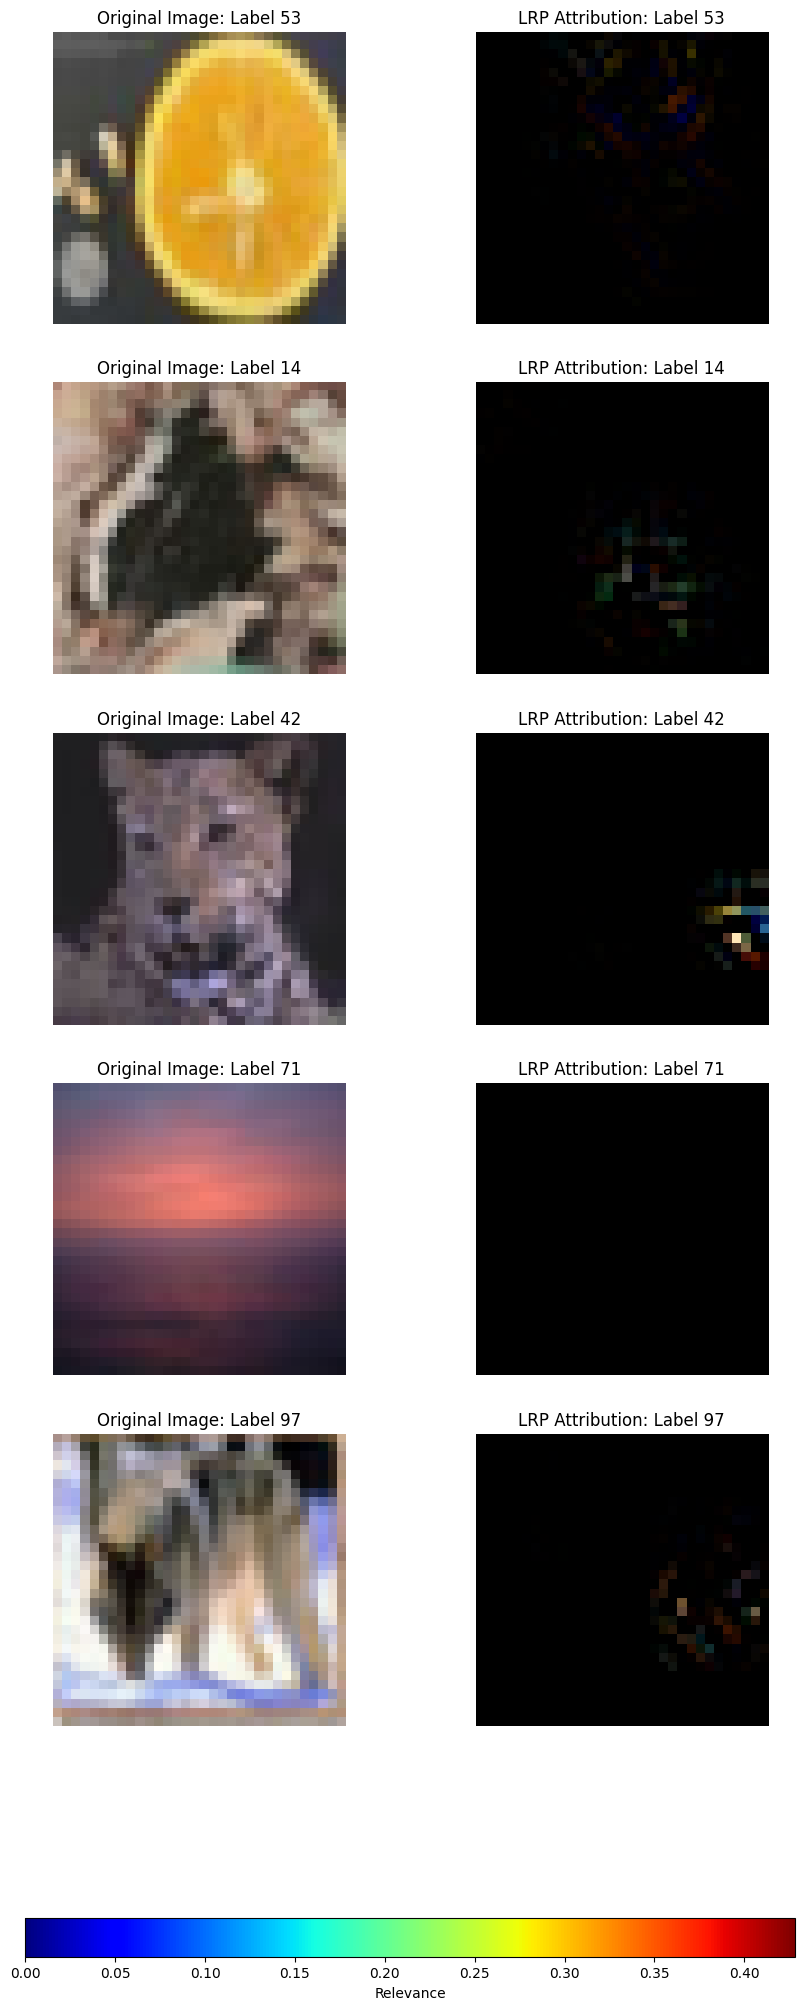

In [56]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
from captum.attr import LRP

def imshow(images, labels, lrp_attributions):
    if isinstance(images, torch.Tensor):
        images = images.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().cpu().numpy()
    if isinstance(lrp_attributions, torch.Tensor):
        lrp_attributions = lrp_attributions.detach().cpu().numpy()

    images = images / 2 + 0.5

    lrp_attributions = np.maximum(lrp_attributions, 0)
    lrp_attributions = lrp_attributions - np.min(lrp_attributions)
    lrp_attributions = lrp_attributions / np.max(lrp_attributions)

    cmap = plt.get_cmap('jet')

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title(f"Original Image: Label {labels[i]}")
        axes[i, 0].axis('off')

        im_lrp = axes[i, 1].imshow(np.transpose(lrp_attributions[i], (1, 2, 0)), cmap=cmap)
        axes[i, 1].set_title(f"LRP Attribution: Label {labels[i]}")
        axes[i, 1].axis('off')

    cbar = fig.colorbar(im_lrp, ax=axes, orientation='horizontal', fraction=0.02, pad=0.1)
    cbar.set_label('Relevance', rotation=0)

    plt.show()

data_iter = iter(testloader)
images, labels = next(data_iter)

random_indices = random.sample(range(images.size(0)), 5)

selected_images = images[random_indices].to('cuda')
selected_labels = labels[random_indices].to('cuda')


lrp = LRP(model)


lrp_attributions = lrp.attribute(selected_images, target=selected_labels)

imshow(selected_images, selected_labels, lrp_attributions)
